In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import statistics
import os, torch
import numpy as np
import pandas as pd
import scienceplots
import h5py
from tqdm.notebook import tqdm 

plt.style.use(['science', 'ieee'])
plt.rcParams["text.usetex"] = False
plt.rcParams['figure.figsize'] = 6, 2

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder
from torch.nn import TransformerDecoder
import math

lr = 0.0001
dims = 4

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model, dtype=torch.float)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model).float() * (-math.log(10000.0) / d_model))
        pe += torch.sin(position * div_term)
        pe += torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x, pos=0):
        x = x + self.pe[pos:pos+x.size(0)]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=16, dropout=0):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU(True)

    def forward(self, src,src_mask=None, src_key_padding_mask=None, is_causal=None):
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        return src

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=16, dropout=0):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = nn.LeakyReLU(True)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt2 = self.self_attn(tgt, tgt, tgt)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.multihead_attn(tgt, memory, memory)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt


# Proposed Model + Self Conditioning + Adversarial + MAML (VLDB 22)
class TranAD(nn.Module):
    def __init__(self, feats):
        super(TranAD, self).__init__()
        self.name = 'TranAD'
        self.lr = lr
        self.batch = 2048
        self.n_feats = feats
        self.n_window = 10
        self.n_window_start = self.n_window
        self.n_window_slide = 1


        self.pos_encoder = PositionalEncoding(2 * feats, 0.1, self.n_window)
        encoder_layers = TransformerEncoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=128, dropout=0.1)
        self.transformer_encoder = TransformerEncoder(encoder_layers, 1)
        decoder_layers1 = TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=128, dropout=0.1)
        self.transformer_decoder1 = TransformerDecoder(decoder_layers1, 1)
        decoder_layers2 = TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=128, dropout=0.1)
        self.transformer_decoder2 = TransformerDecoder(decoder_layers2, 1)
        self.fcn = nn.Sequential(nn.Linear(2 * feats, feats), nn.Sigmoid())

    def encode(self, src, c, tgt):
        src = torch.cat((src, c), dim=2)
        src = src * math.sqrt(self.n_feats)
        src = self.pos_encoder(src)
        memory = self.transformer_encoder(src)
        tgt = tgt.repeat(1, 1, 2)
        return tgt, memory

    def forward(self, src, tgt):
        # Phase 1 - Without anomaly scores
        c = torch.zeros_like(src)
        x1 = self.fcn(self.transformer_decoder1(*self.encode(src, c, tgt)))
        x12 = self.fcn(self.transformer_decoder2(*self.encode(src, c, tgt)))
        # Phase 2 - With anomaly scores
        c = (x1 - src) ** 2
        x2 = self.fcn(self.transformer_decoder2(*self.encode(src, c, tgt)))
        return x1, x2, x12

class AlladiCNNLSTM(nn.Module):
    def __init__(self, feats):
        super(AlladiCNNLSTM, self).__init__()
        self.name = 'AlladiCNNLSTM'
        self.batch = 128
        self.lr = lr
        self.n_feats = feats
        self.n_window = 10
        self.n_window_slide = 1
        self.n_window_start = self.n_window
        self.n_hidden = 256
        self.n_layers = 4

        # Define the CNN layers
        self.cnn = nn.Conv1d(feats, 20, kernel_size=3)

        # Define the LSTM layers
        self.lstm = nn.LSTM(20, self.n_hidden, self.n_layers, batch_first=True)

        # Fully connected layer
        # self.fc = nn.Sequential(nn.Linear(20 * self.n_hidden, self.n_feats), nn.Sigmoid())
        self.fc = nn.Sequential(nn.Linear(self.n_hidden, self.n_feats), nn.Sigmoid())

    def forward(self, src):
        # Forward pass through CNN
        src = src.permute(1, 2, 0)
        src = self.cnn(src)
        src = src.permute(0, 2, 1)

        # Forward pass through LSTM
        out, _ = self.lstm(src)

        # out = out.reshape(-1, out.shape[1] * out.shape[2])
        out = out[:, -1]
        # Decode the hidden state of the last time step
        out = self.fc(out)

        return out.unsqueeze(0)

    
def load_model(model_class, checkpoint):
    model = model_class(dims)
    model.to(device)
    if os.path.exists(checkpoint):
        print(f"Loading pre-trained model: {model.name}")
        checkpoint = torch.load(checkpoint, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        accuracy_list = checkpoint['accuracy_list']

    return model, accuracy_list

In [7]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class HDF5Dataset(Dataset):
    def __init__(self, h5_data, chunk_size=1000, device='cpu', less=False):
        self.h5_data = h5_data
        if less:
            self.h5_data = cut_array_window_first(0.2, self.h5_data)
        self.device = device
        self.chunk_size = chunk_size
        self.chunk_start = -1
        self.chunk_end = 0
        self.chunk(0)
        
    def chunk(self, idx):
        if  idx < self.chunk_start or idx >= self.chunk_end:
            self.chunk_start = (idx // self.chunk_size) * self.chunk_size
            self.chunk_end = self.chunk_start + self.chunk_size
            chunk = self.h5_data[:, self.chunk_start:self.chunk_end]
            if hasattr(self, '_chunk'):
                del self._chunk
            self._chunk = torch.from_numpy(chunk).float().to(self.device)
        bounded_idx = idx - self.chunk_start
        return self._chunk, bounded_idx

    def __len__(self):
        return self.h5_data.shape[1]

    def __getitem__(self, idx):
        chunk, bounded_idx = self.chunk(idx)
        data = chunk[:, bounded_idx]
        return data, data

In [8]:
def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)

    acc = (TP + TN) / (TP + FP + TN + FN)  # + 0.00001)
    precision = TP / (TP + FP)  # + 0.00001)
    recall = TP / (TP + FN)  # + 0.00001)
    f1 = 2 * precision * recall / (precision + recall)  # + 0.00001)
    try:
        roc_auc = roc_auc_score(actual, predict)
    except:
        roc_auc = 0
    p_t = f1, precision, recall, TP, TN, FP, FN, roc_auc, acc
    metrics = {
        'f1': p_t[0],
        'precision': p_t[1],
        'recall': p_t[2],
        'TP': p_t[3],
        'TN': p_t[4],
        'FP': p_t[5],
        'FN': p_t[6],
        'ROC/AUC': p_t[7],
        'accuracy': p_t[8],
        # 'pot-latency': p_latency
    }
    return metrics


In [9]:
model, acc_list = load_model(AlladiCNNLSTM, 'checks/AlladiCNNLSTM_VeReMiH510/model-e19.ckpt')
loss = nn.MSELoss(reduction = 'none')

Loading pre-trained model: AlladiCNNLSTM


In [10]:
f = h5py.File('out_veremi/veremi-atk-10.h5')
bs = 5000
dataset = HDF5Dataset(f['test'], chunk_size=bs * 100, device=device)
dataloader = DataLoader(dataset, batch_size=bs)

In [11]:
def smooth(y, box_pts=1):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_curve(y_t, y_p, l, a_s, p, title, final=False, first=False, thresh=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.set_ylabel('Value')
    ax1.set_title(title)
    if not final:
        ax1.plot(smooth(y_t), linewidth=0.2, label='True')
        ax1.plot(smooth(y_p), '-', alpha=0.6, linewidth=0.3, label='Predicted')
    ax3 = ax1.twinx()
    # ax3.plot(l, '--', linewidth=0.1, alpha=0.5)
    # ax3.fill_between(np.arange(l.shape[0]), l, color='blue', alpha=0.3)
    # ax4 = ax1.twinx()
    # ax4.plot(p, '--', linewidth=0.1, alpha=0.5)
    # ax4.fill_between(np.arange(p.shape[0]), p, color='red', alpha=0.3)
    if first: ax1.legend(ncol=2, bbox_to_anchor=(0.6, 1.02))
    ax2.plot(smooth(a_s), linewidth=0.2, color='g')
    ax2.axhline(y=thresh, color='r', linestyle='--', linewidth=0.2, label='Threshold')
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Anomaly Score')


In [30]:
def test_all():
    losses = []
    zs = []
    for d, _ in tqdm(dataloader):
        d = d.to(device)
        local_bs = d.shape[0]
        window = d.permute(1, 0, 2)
        elem = window[-1, :, :].view(1, local_bs, dims)
        z = model(window)
        if isinstance(z, tuple): z = z[1]
        l = loss(z, elem)[0]
        zs.append(z.cpu().detach())
        losses.append(l.cpu().detach())
        
    l = torch.cat(losses, 0)
    z = torch.cat(zs, 1)
    return l.detach().cpu().numpy(), z.detach().cpu().numpy()[0]

all_loss, all_z = test_all()

  0%|          | 0/159 [00:00<?, ?it/s]

In [31]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(precision, recall):
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def find_optimal_threshold(mean_score, labels, plot=True):
    precision, recall, thresholds = precision_recall_curve(
        labels > 0, mean_score)
    f1_scores = 2*recall*precision/(recall+precision)

    if plot:
        plot_pr_curve(precision, recall)

    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = np.max(f1_scores)

    return best_threshold, best_f1

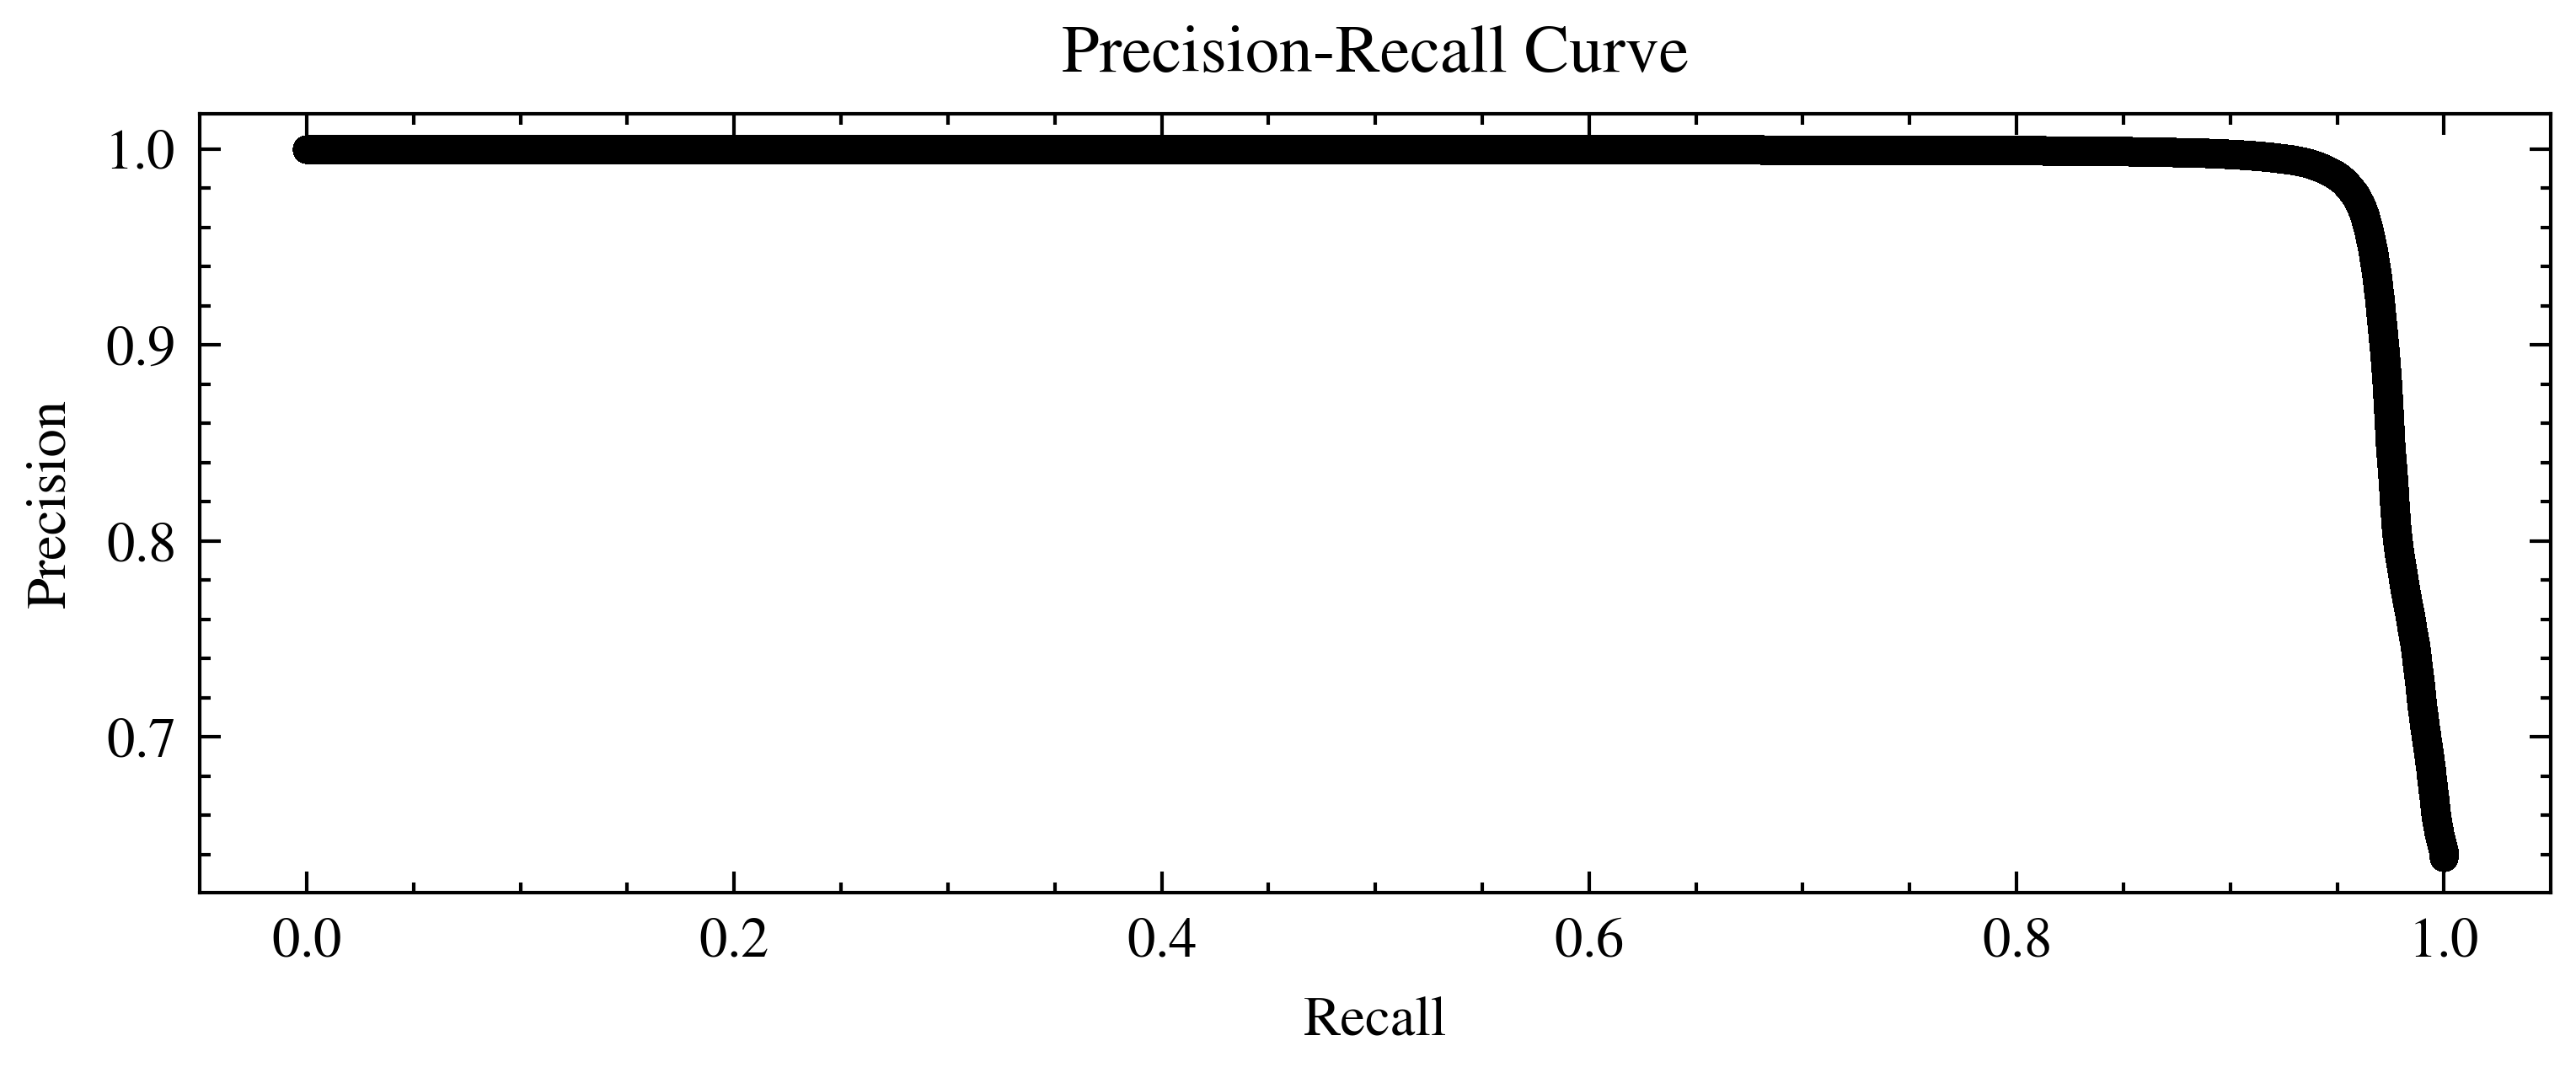

(3.2835155e-07, 0.9680625351200131)

In [32]:
all_loss_mean = np.mean(all_loss, axis=1)
label = f['test_labels'][:, 0]
find_optimal_threshold(all_loss_mean, label)

In [103]:
# from collections import defaultdict

# T = 0.00010745111

# label_seq = f['test_labels'][:, 2]
# label = f['test_labels'][:, 0]
# changes = np.diff(label_seq)
# indices = np.where(changes != 0)[0] + 1
# preds = all_loss_mean > T
# group_splits = np.split(preds, indices)

# anomalies_for_attack = defaultdict(int)
# n_of_seqs = defaultdict(int)

# for group, label in tqdm(zip(group_splits, label[indices]), total=len(group_splits)):
#     anomalies_for_attack[label] += sum(group)
#     n_of_seqs[label] += len(group)

# avg_num_of_anomalies_per_attack = {}
# for label in anomalies_for_attack.keys():
#     avg_num_of_anomalies_per_attack[label] = anomalies_for_attack[label] / n_of_seqs[label]

# out = sorted(avg_num_of_anomalies_per_attack.keys(), key=avg_num_of_anomalies_per_attack.get)
# for k in out:
#     print(k, avg_num_of_anomalies_per_attack[k])

  0%|          | 0/26972 [00:00<?, ?it/s]

12 0.6172709051988602
0 0.6178838829982668
8 0.6354321618081303
7 0.6382570080488482
3 0.638781120296832
9 0.6393154859153324
1 0.6430421378696353
6 0.6448554299654253
5 0.6454906109494842
4 0.6458339127567176
10 0.6468717366358413
11 0.6485682475124771
2 0.657345274210249
17 0.6730837112058432
18 0.6923554309843044
13 0.6948563643092357
19 0.697743222549023
14 0.7048093319152191
16 0.7120644965035857
15 0.7166946695123613


In [12]:
attack_to_group = {}
attack_types = np.unique(f['test_labels'][:, 0])
mid = f['test_labels'].shape[0] // 2
for attack_type in tqdm(attack_types):
    idxs = f['test_labels'][:, 0] == attack_type
    attack_to_group[attack_type] = np.unique(f['test_labels'][:, 2][idxs])

  0%|          | 0/9 [00:00<?, ?it/s]

In [28]:
attack_to_group[13][0]

22

In [7]:
fps = []
sizes = []
pctgs = []

group_idx = np.isin(f['test_labels'][:, 2], attack_to_group[0])
print('a')
#preds, l = eval_group(f, group_idx)
print('b')
# for i in (pbar := tqdm()): #[-4000:-3500]):
#     l = l.mean(axis=1)
#     s = np.sum(l > 0.0005618696491893652)
#     size = np.sum(group_idx)
#     pctg = 100 * s / size
#     fps.append(s)
#     sizes.append(size)
#     pctgs.append(pctg)
#     pbar.set_description(f"Last FP {s}, Last Size {size}: {pctg:.4}")

a
b


In [26]:
def eval_group(h5file, group_idx):
    values = h5file['test'][:, group_idx]
    test = torch.tensor(values, device=device)
    tgt = test[-1].unsqueeze(0)
    if model.name == 'TranAD':
        params = (test, tgt)
    else:
        params = (test,)
    out = model(*params)
    if isinstance(out, tuple): out = out[1]
    l = loss(out, tgt).detach().cpu().numpy()[0]    
    return out.detach().cpu().numpy(), l


def plot_group(h5file, group, thresh):
    group_idx = h5file['test_labels'][:, 2] == group
    values = h5file['test'][-1, group_idx]
    labels = h5file['test_labels'][group_idx, 0]
    preds, l = eval_group(h5file, group_idx)
    fig, axes = plt.subplots(nrows=2 * (values.shape[1] + 1), ncols=1, sharex=True, figsize=(10, 20))
    
    for i in range(0, values.shape[1] * 2, 2):
        feat = i // 2
        axes[i].title.set_text(str(feat))
        axes[i].plot(values[:, feat], linewidth=0.2, color='b')
        axes[i].plot(preds[0, :, feat], '-', alpha=0.6, linewidth=0.3, color='r')
        axes[i].grid()
        
        axes[i + 1].plot(l[:, feat], '-', alpha=0.6, linewidth=0.3, color='g')
        axes[i + 1].grid()

    axes[-2].plot(values.mean(axis=1), linewidth=0.2, color='b')
    axes[-2].plot(preds[0, :].mean(axis=1), '-', alpha=0.6, linewidth=0.3, color='r')
    axes[-2].grid()
    
    axes[-1].plot(l.mean(axis=1), '-', alpha=0.6, linewidth=0.3, color='g')
    axes[-1].axhline(y=thresh, color='r', linestyle='--', linewidth=0.2, label='Threshold')
    axes[-1].grid()

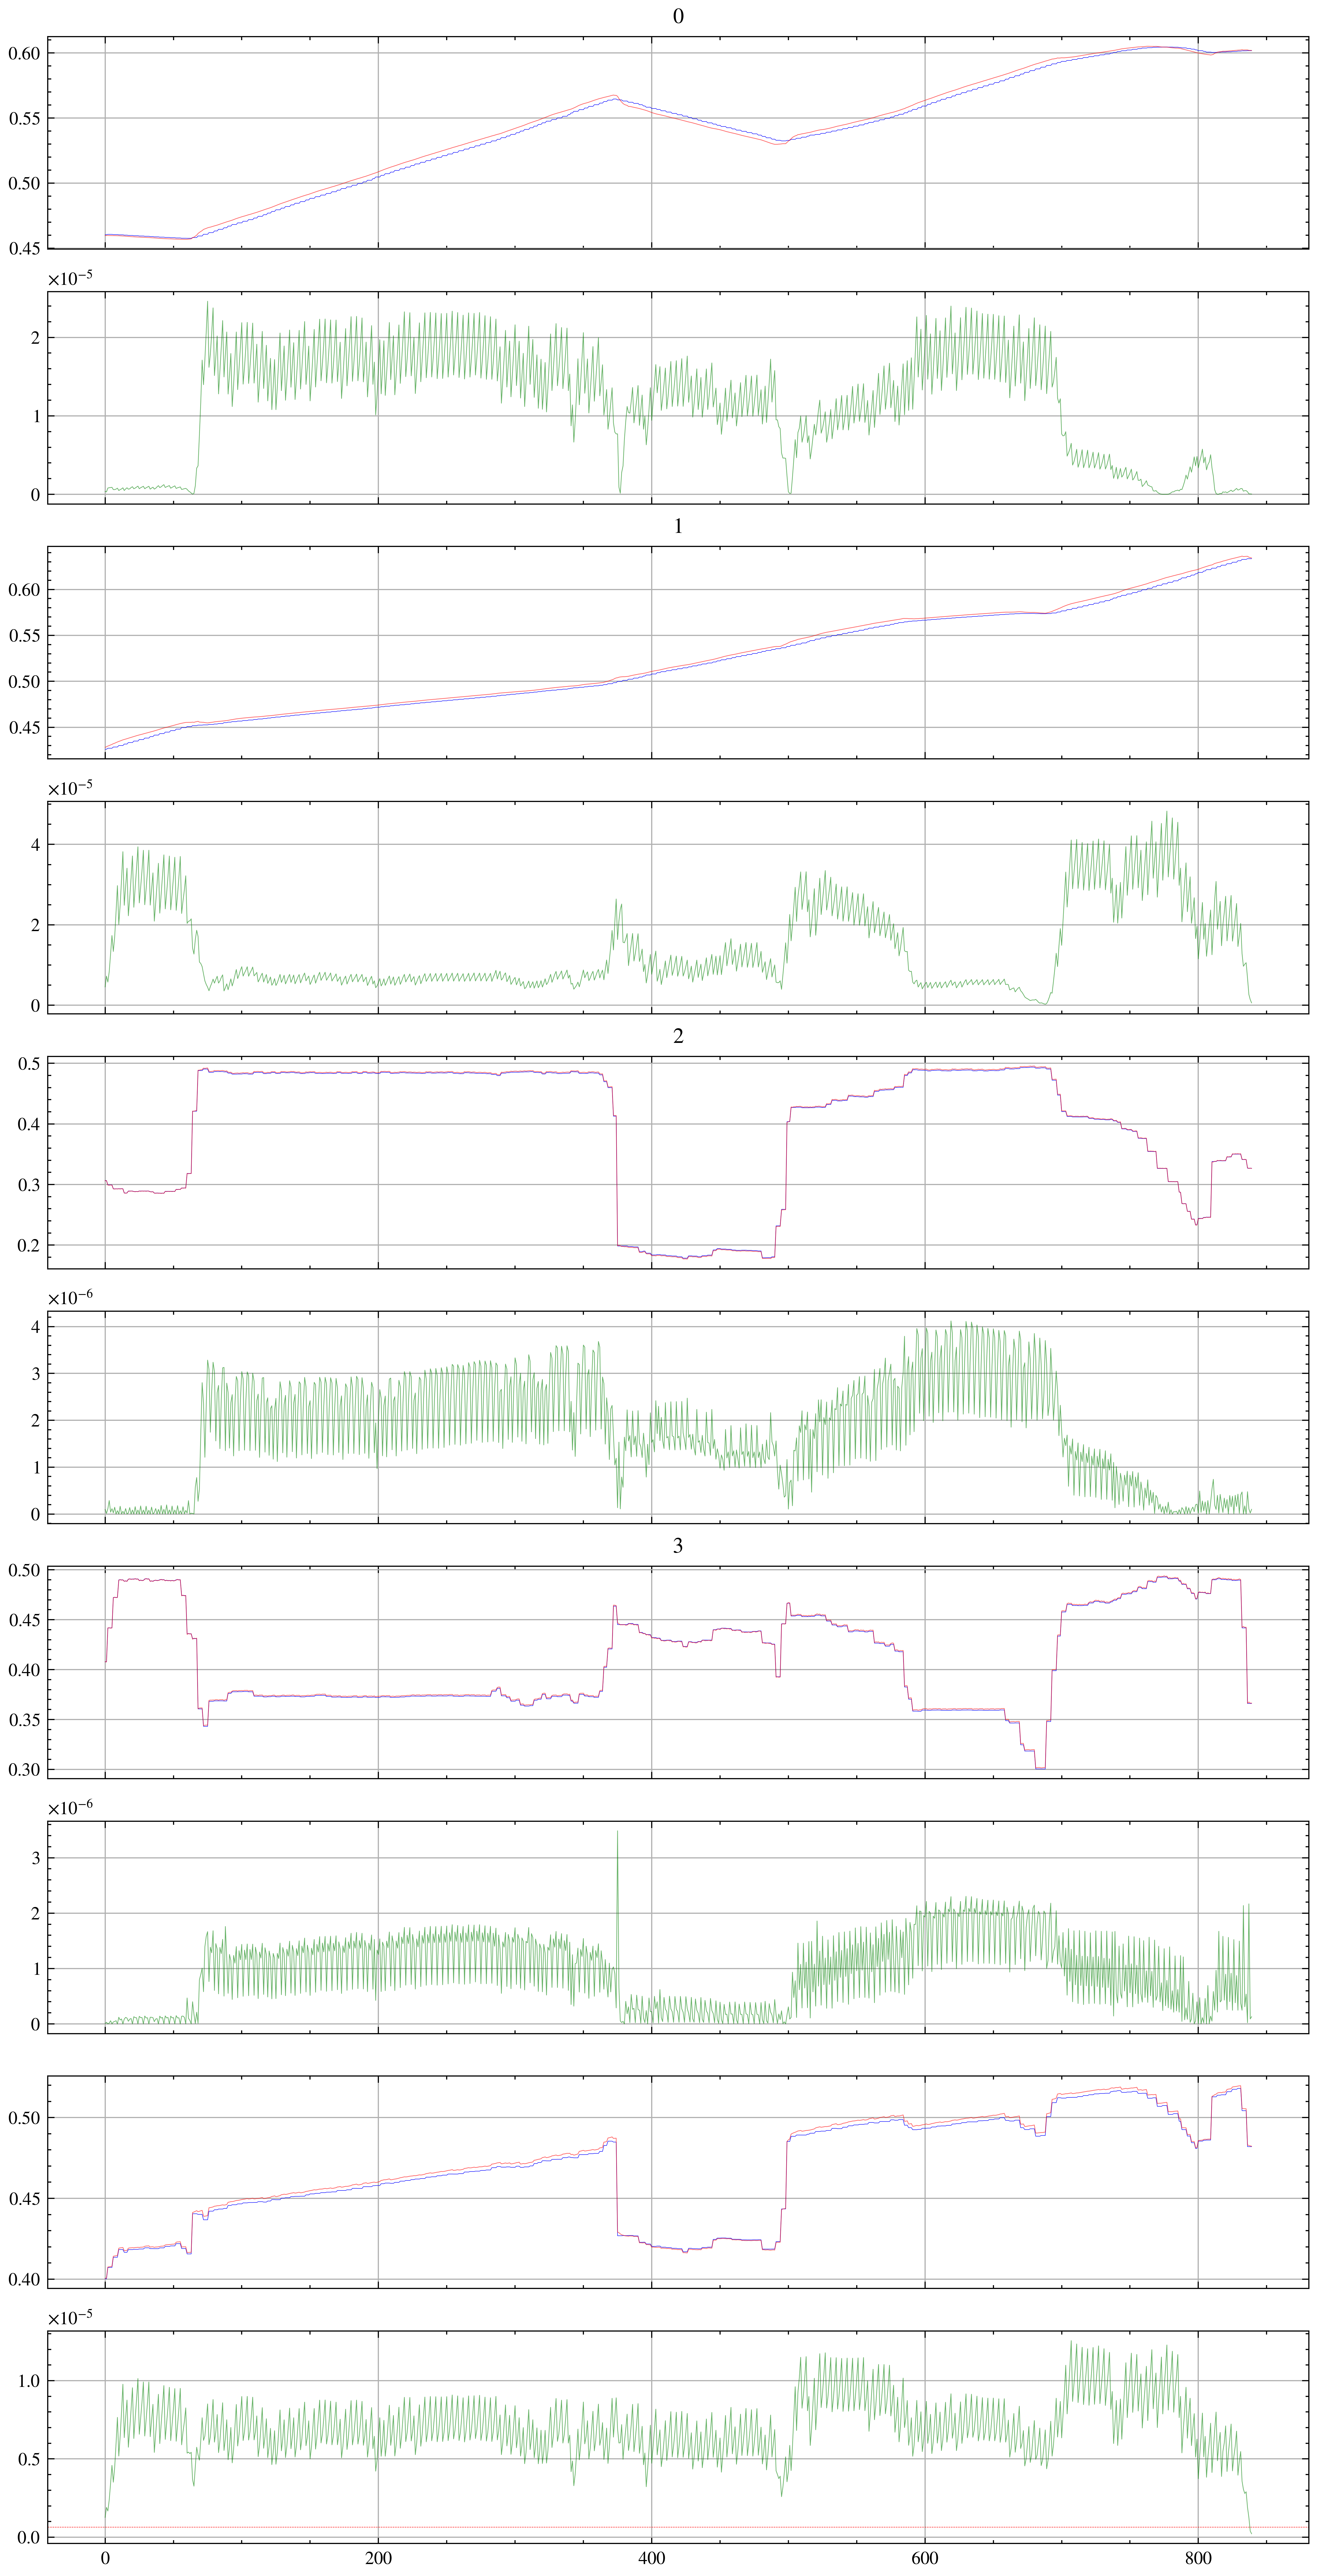

In [29]:
T = 6.47866045255796e-07

plot_group(f, 22, T)

In [8]:
def eval_group_20_10(h5file, group_idx):
    values = h5file['test'][:, group_idx]
    test = torch.tensor(values, device=device)
    out = model(test)
    if isinstance(out, tuple): out = out[2]
    l = loss(out, test).detach().cpu().numpy()[0]
    return out.detach().cpu().numpy(), l


def plot_group_20_10(h5file, group, thresh, cut_start=True):
    group_idx = h5file['test_labels'][:, 2] == group
    values = h5file['test'][10:, group_idx].reshape(-1, h5file['test'].shape[2])
    # labels = h5file['test_labels'][group_idx, 0]
    
    preds, l = eval_group2(h5file, group_idx)
    preds = preds.reshape(-1, preds.shape[2])
    l = np.mean(l, axis=(0, 2))
    fig, axes = plt.subplots(nrows=2 * (values.shape[1] + 1), ncols=1, sharex=True, figsize=(10, 20))
    
    for i in range(0, values.shape[1] * 2, 2):
        feat = i // 2
        axes[i].title.set_text(str(feat))
        axes[i].plot(smooth(values[:, feat]), linewidth=0.2, color='b')
        axes[i].plot(smooth(preds[0, :, feat]), '-', alpha=0.6, linewidth=0.3, color='r')
        axes[i].grid()
        
        axes[i + 1].plot(smooth(l[:, feat]), '-', alpha=0.6, linewidth=0.3, color='g')
        axes[i + 1].grid()

    axes[-2].plot(smooth(values.mean(axis=1)), linewidth=0.2, color='b')
    axes[-2].plot(smooth(preds[0, :].mean(axis=1)), '-', alpha=0.6, linewidth=0.3, color='r')
    axes[-2].grid()
    
    axes[-1].plot(smooth(l.mean(axis=1)), '-', alpha=0.6, linewidth=0.3, color='g')
    axes[-1].axhline(y=thresh, color='r', linestyle='--', linewidth=0.2, label='Threshold')
    axes[-1].grid()

loaded test
torch.Size([10, 21277, 17])


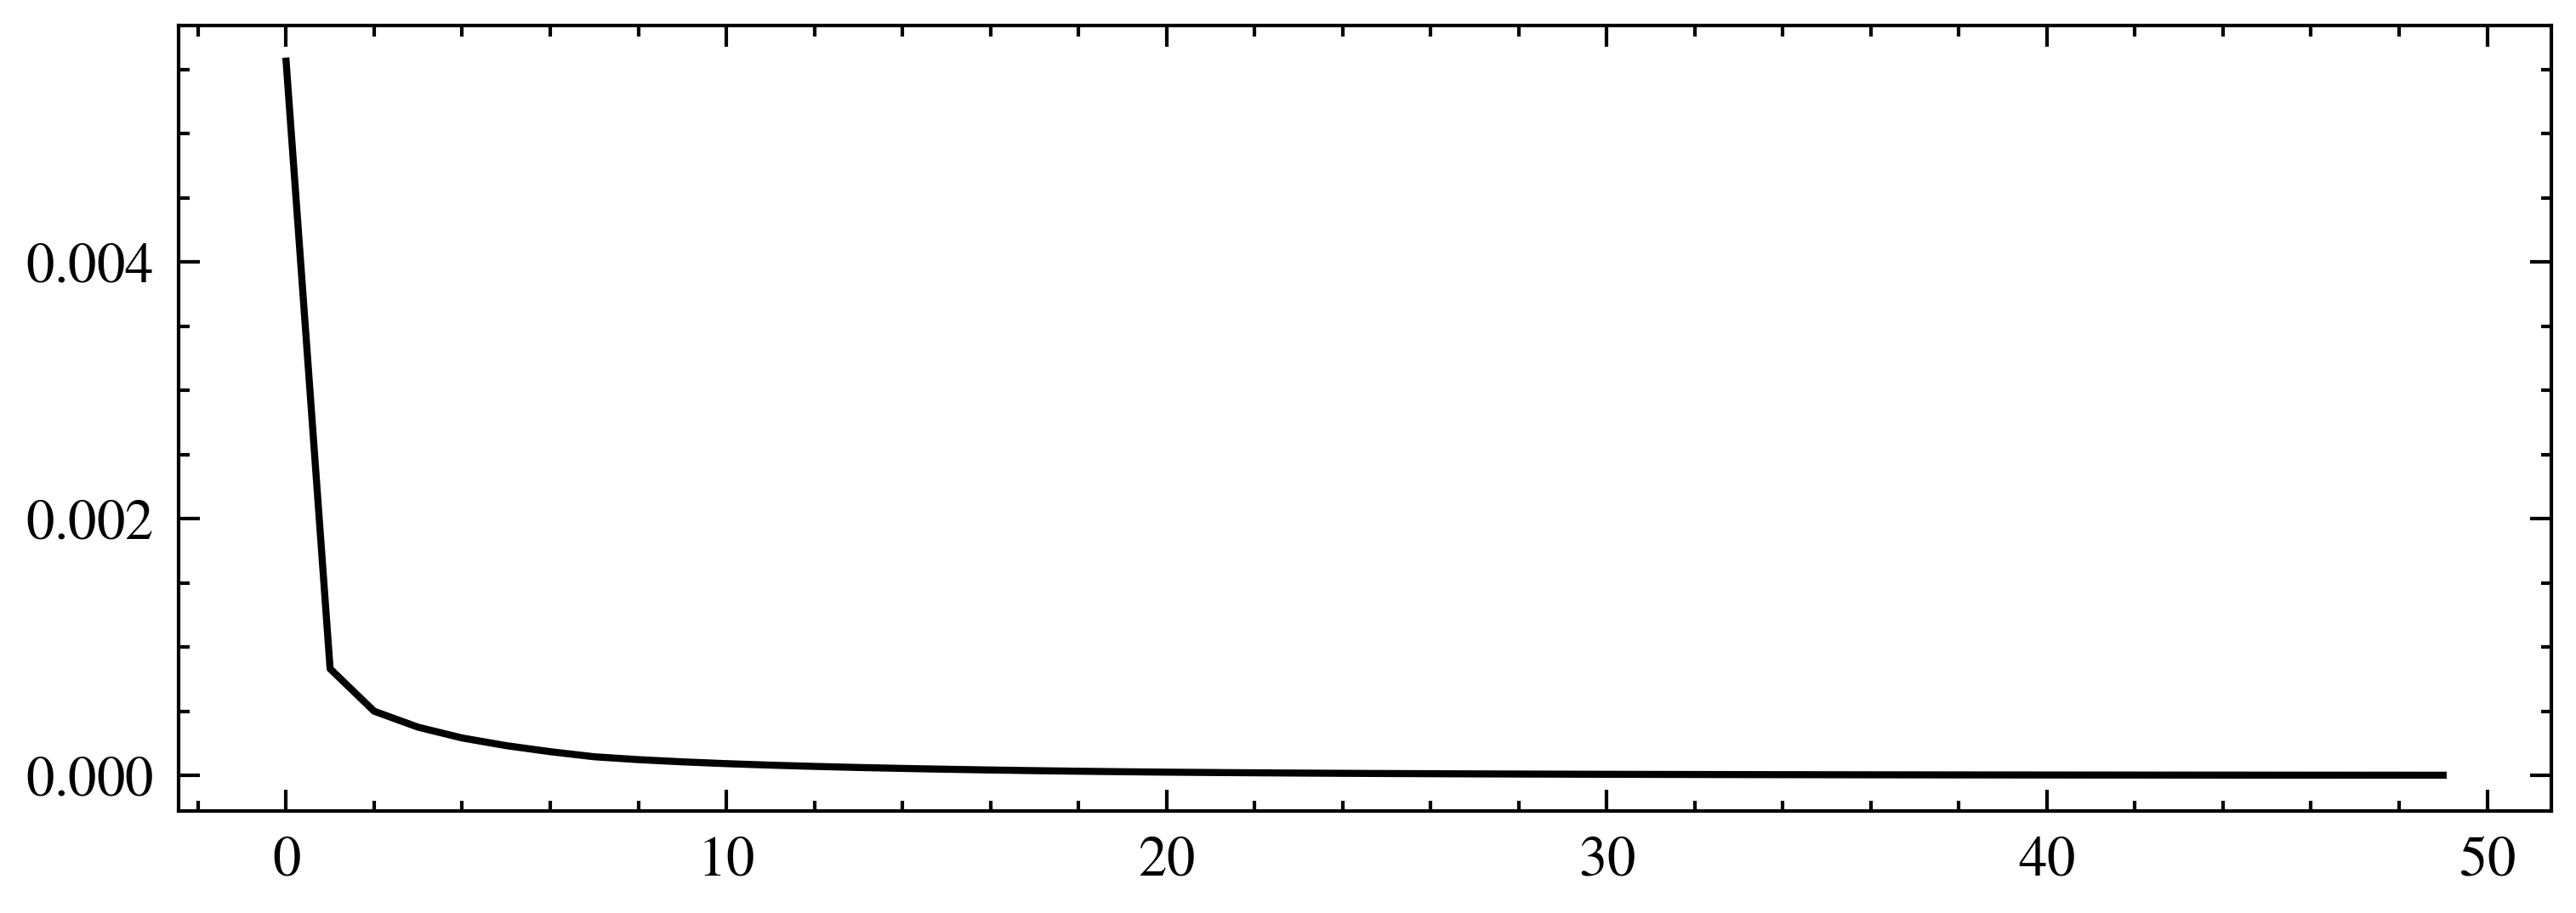

In [68]:
# treinamento
plt.plot(list(map(list, zip(*acc_list)))[0])